In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  3,  8, 10,  9,  2,  0,  6,  4]), tensor([7, 1]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-0.0831],
        [ 1.2405]], grad_fn=<AddmmBackward>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.3882]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.9293], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.5411], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.5411],
        [-0.5411],
        [-0.5411],
        [-0.5411],
        [-0.5411],
        [-0.5411],
        [-0.5411],
        [-0.5411],
        [-0.5411],
        [-0.5411]], grad_fn=<AddmmBackward>)

In [10]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7f984c06d0d0>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.3288]], requires_grad=True), Parameter containing:
 tensor([0.3636], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print('epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, loss_train, loss_val))

In [14]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_c_train = t_c_train,
    t_u_val = t_un_val,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

epoch 1, Training loss 198.44419860839844, Validation loss 102.61880493164062
epoch 1000, Training loss 4.832695960998535, Validation loss 1.1334517002105713
epoch 2000, Training loss 3.008207321166992, Validation loss 2.83974027633667
epoch 3000, Training loss 2.857100009918213, Validation loss 4.479846000671387

Parameter containing:
tensor([[5.5662]], requires_grad=True)
Parameter containing:
tensor([-18.6840], requires_grad=True)


In [15]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [16]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [18]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activate', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1)),
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activate): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [20]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2051], requires_grad=True)

In [23]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

epoch 1, Training loss 1.5183638334274292, Validation loss 6.575335502624512
epoch 1000, Training loss 1.5264345407485962, Validation loss 8.097166061401367
epoch 2000, Training loss 1.5265001058578491, Validation loss 8.29477310180664
epoch 3000, Training loss 1.5229476690292358, Validation loss 8.46280288696289
epoch 4000, Training loss 1.517733097076416, Validation loss 8.617918968200684
epoch 5000, Training loss 1.5117764472961426, Validation loss 8.766664505004883
output tensor([[-0.9541],
        [11.6343]], grad_fn=<AddmmBackward>)
answer tensor([[-4.],
        [14.]])
hidden tensor([[-8.5560e+00],
        [ 2.2080e-03],
        [ 1.7292e-01],
        [ 2.0145e-01],
        [ 8.4137e+00],
        [ 5.9588e+00],
        [-2.1364e-01],
        [ 6.9945e+00]])


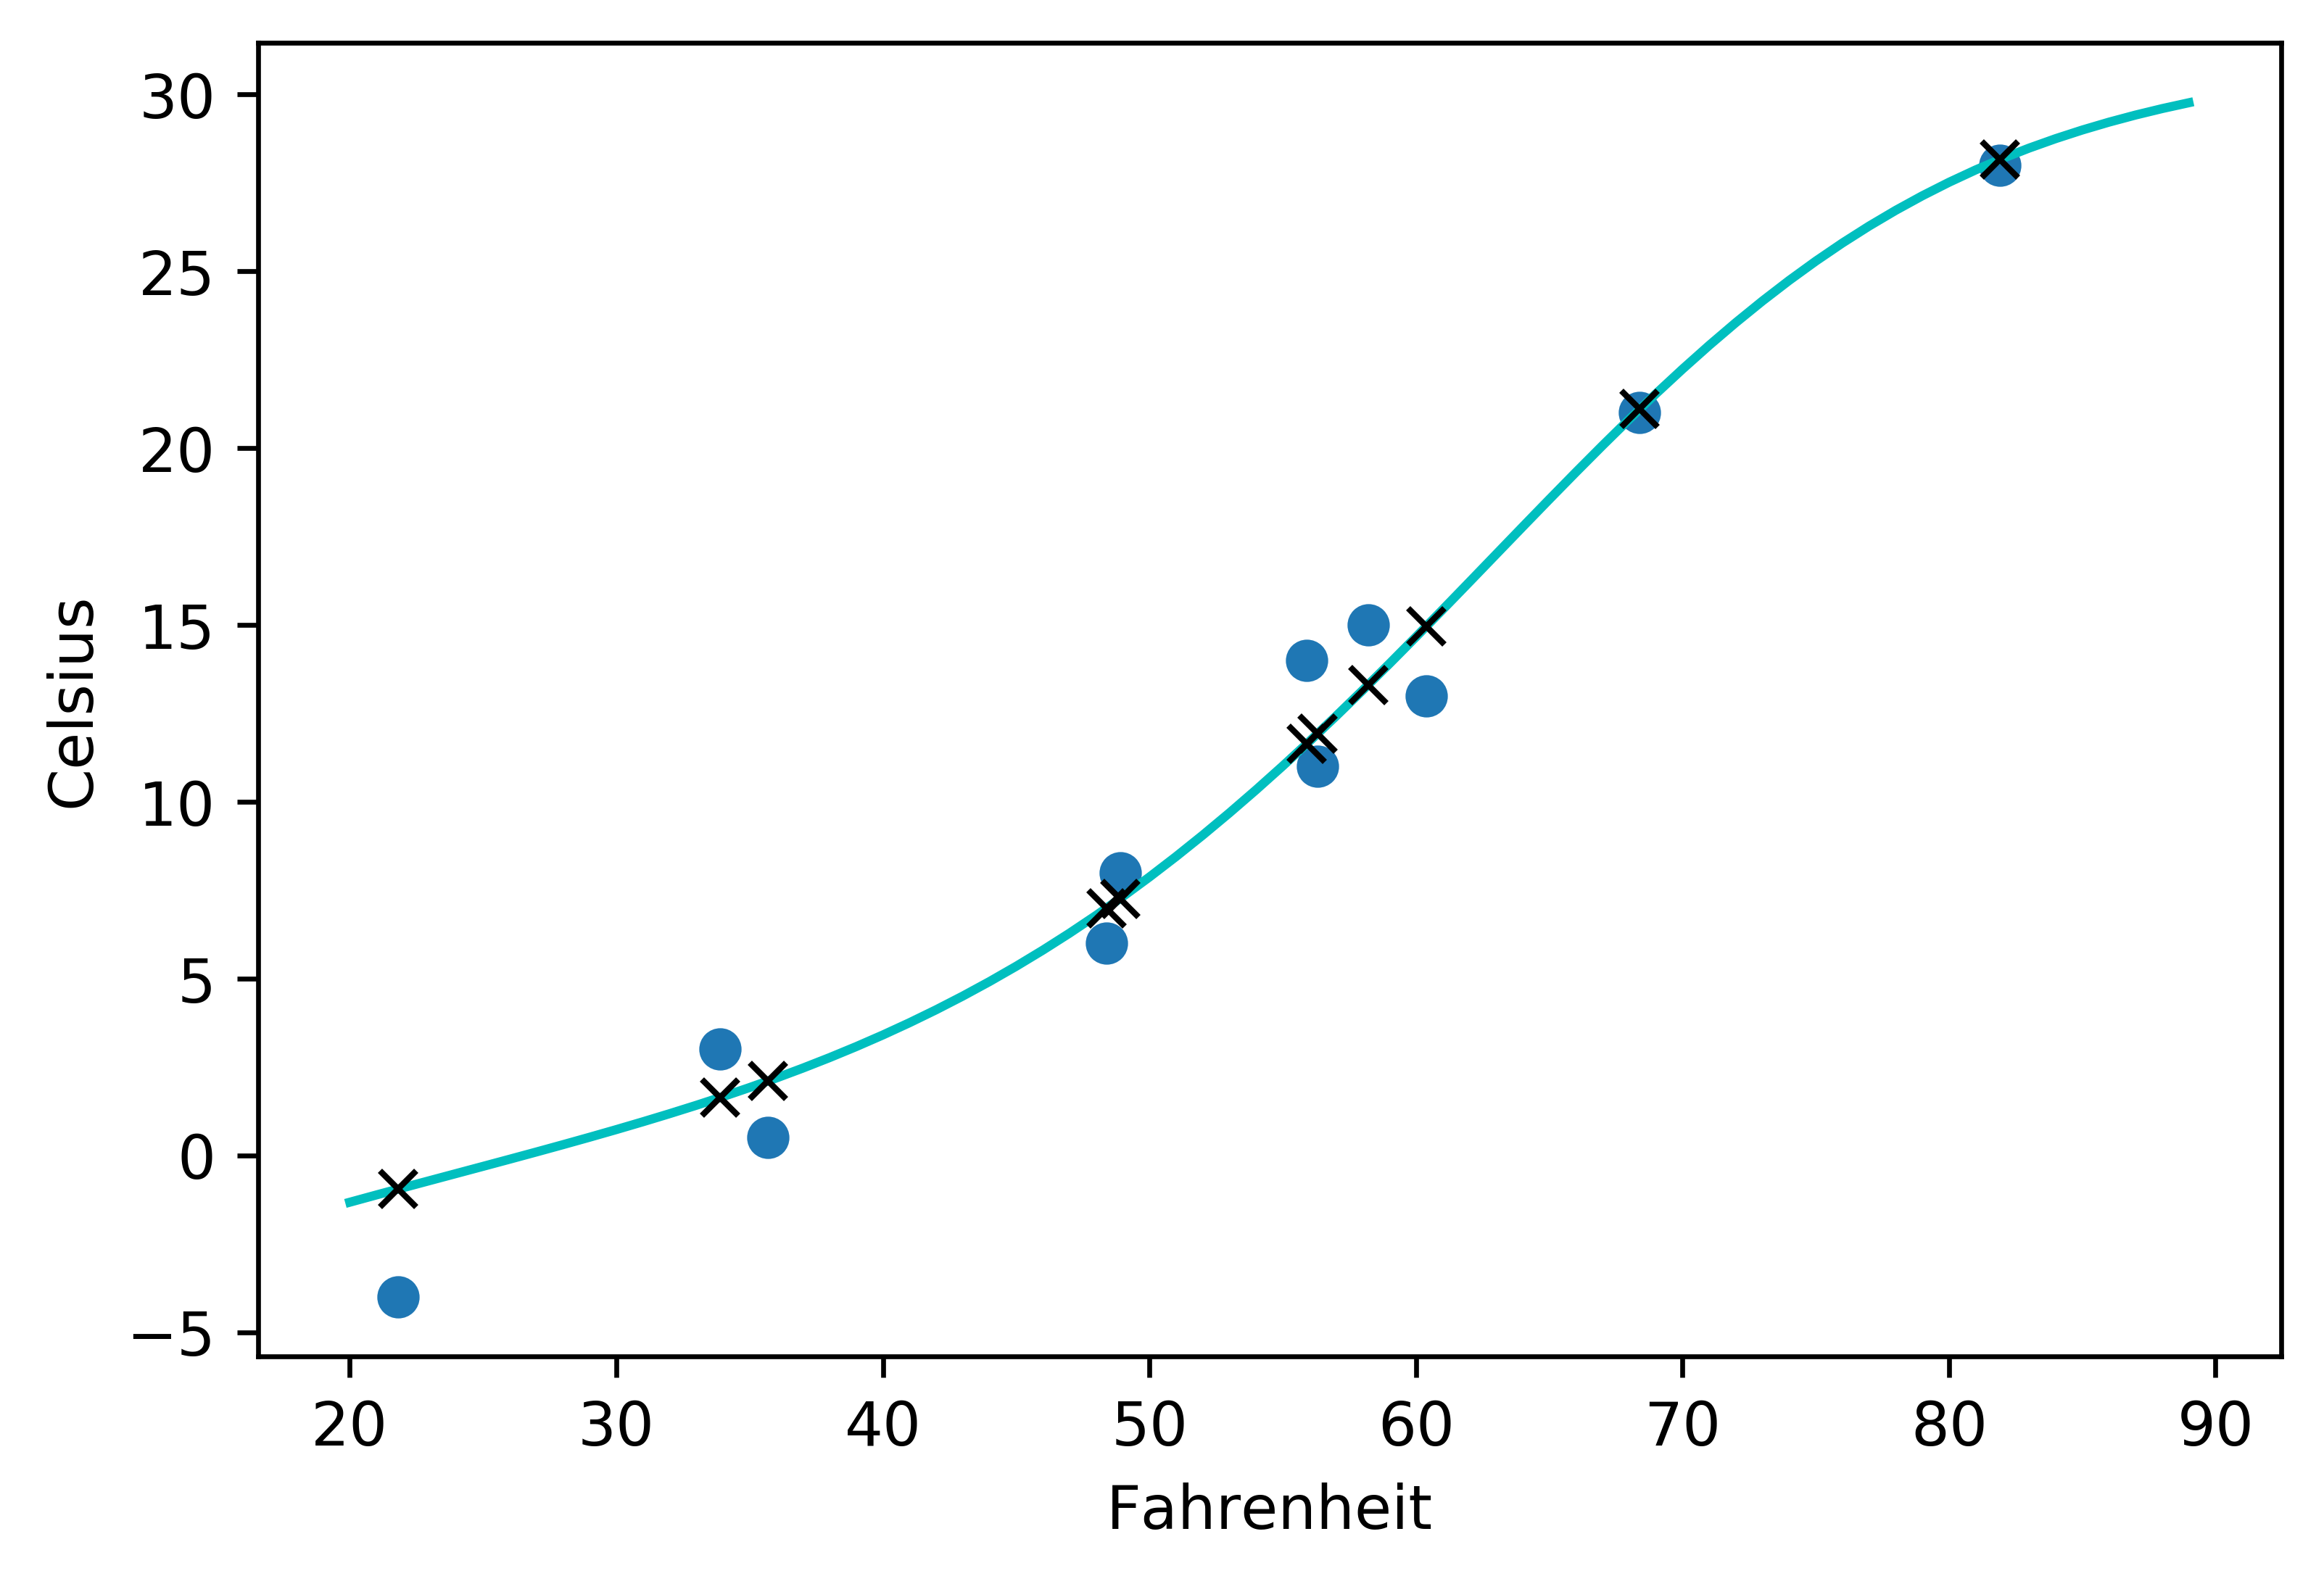

In [24]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel('Fahrenheit')
plt.ylabel('Celsius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')